# 1. Import & Functions

In [1]:
from google.colab.patches import cv2_imshow

In [10]:
import numpy as np
import cv2

H, W = 1000, 1000
a = 5
N = 20
r = 3


class Lattice:
    def __init__(self, lengths, angles):
        self.length = lengths
        self.angle = angles

        self.a = lengths[0]
        self.b = lengths[1]
        self.c = lengths[2]

        self.alpha = angles[0] / 180 * np.pi
        self.beta = angles[1] / 180 * np.pi
        self.gamma = angles[2] / 180 * np.pi

        self.ab = self.a * self.b * np.cos(self.gamma)
        self.ba = self.a * self.b * np.cos(self.gamma)

        self.bc = self.b * self.c * np.cos(self.alpha)
        self.cb = self.b * self.c * np.cos(self.alpha)

        self.ca = self.c * self.a * np.cos(self.beta)
        self.ac = self.c * self.a * np.cos(self.beta)

        self.a_b = np.sqrt(self.a**2 + self.b**2 - 2 * self.a * self.b * np.cos(self.gamma))
        self.b_a = np.sqrt(self.a**2 + self.b**2 - 2 * self.a * self.b * np.cos(self.gamma))

        self.b_c = np.sqrt(self.b**2 + self.c**2 - 2 * self.b * self.c * np.cos(self.alpha))
        self.c_b = np.sqrt(self.b**2 + self.c**2 - 2 * self.b * self.c * np.cos(self.alpha))

        self.c_a = np.sqrt(self.c**2 + self.a**2 - 2 * self.c * self.a * np.cos(self.beta))
        self.a_c = np.sqrt(self.c**2 + self.a**2 - 2 * self.c * self.a * np.cos(self.beta))

    def index_to_parallelogram(self, ind_1, ind_2, ind_3):
        if ind_1 == ind_2 == ind_3 == 1:
            length_1 = self.b_a
            length_2 = self.c_a
            angle = np.arccos((self.bc - self.ca - self.ba + self.a**2) / (self.b_a * self.c_a))
        elif (ind_1 == ind_2 == 1) and (ind_3 == 0):
            length_1 = self.c
            length_2 = self.b_a
            angle = np.arccos((self.bc - self.ac) / (self.b_a * self.c))
        elif (ind_2 == ind_3 == 1) and (ind_1 == 0):
            length_1 = self.a
            length_2 = self.c_b
            angle = np.arccos((self.ca - self.ba) / (self.c_b * self.a))
        elif (ind_3 == ind_1 == 1) and (ind_2 == 0):
            length_1 = self.b
            length_2 = self.a_c
            angle = np.arccos((self.ab - self.cb) / (self.a_c * self.b))
        elif (ind_1 == 1) and (ind_2 == ind_3 == 0):
            length_1 = self.b
            length_2 = self.c
            angle = self.alpha
        elif (ind_2 == 1) and (ind_3 == ind_1 == 0):
            length_1 = self.c
            length_2 = self.a
            angle = self.beta
        elif (ind_3 == 1) and (ind_1 == ind_2 == 0):
            length_1 = self.a
            length_2 = self.b
            angle = self.gamma
        else:
            raise print("Invalid indexes inputted.")

        return length_1, length_2, angle / np.pi * 180


def generate_lattice_image(lattice, index, H=H, W=W, a=a, N=N, r=r):
    lattice_image = np.zeros((H, W))
    l_a, l_b, theta = lattice.index_to_parallelogram(index[0], index[1], index[2])
    center = (H//2, W//2)

    for x in range(-N, N + 1):
        for y in range(-N, N + 1):
            position_x = center[0] + int(a * (x * l_a + y * l_b * np.cos(theta / 180 * np.pi)))
            position_y = center[1] + int(a * y * l_b * np.sin(theta / 180 * np.pi))
            position = (position_y, position_x)
            lattice_image = cv2.circle(lattice_image, position, r, 1, thickness=-1)

    return lattice_image


def simulate_matching(
    substrate: Lattice,
    film: Lattice,
    substrate_indexes: list = [(1,0,0), (1,1,0), (1,1,1)],
    film_indexes: list = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)],
    step: float = 1,
):

    angles = np.arange(0, 90 + step, step=step)
    out = {}

    for base_index in substrate_indexes:
        for on_index in film_indexes:
            head = f"Substrate({base_index[0]}{base_index[1]}{base_index[2]})//Film({on_index[0]}{on_index[1]}{on_index[2]})"

            base = generate_lattice_image(substrate, base_index)
            on = generate_lattice_image(film, on_index)

            y = []

            for angle in angles:
                trans = cv2.getRotationMatrix2D((H//2, W//2), angle, 1.0)
                on_rot = cv2.warpAffine(on, trans, (W, H))
                value = np.sum((on_rot * base)[H//4:H//4*3,W//4:W//4*3])
                y.append(value)

            ind_max = np.argmax(y)
            angle_max = angles[ind_max]
            overlap_max = y[ind_max]

            trans = cv2.getRotationMatrix2D((H//2, W//2), angle_max, 1.0)
            on_rot = cv2.warpAffine(on, trans, (W, H))
            print(f"\n{head}, θ_max={angle_max:.1f}°, A_max={overlap_max:.0f}px")
            base_show = cv2.cvtColor((base * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
            on_rot_show = cv2.cvtColor((on_rot * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

            base_show[:,:,0] = 0
            base_show[:,:,2] = 0
            on_rot_show[:,:,0] = 0
            on_rot_show[:,:,1] = 0
            out_image = (255 - base_show/2 - on_rot_show/2)[H//4:H//4*3,W//4:W//4*3]

            h, w, _ = out_image.shape

            s_a, s_b, s_angle = substrate.index_to_parallelogram(base_index[0], base_index[1], base_index[2])
            t_a, t_b, t_angle = film.index_to_parallelogram(on_index[0], on_index[1], on_index[2])

            cv2.line(
                out_image,
                pt1=(w//2, h//2),
                pt2=(w//2, h//2-int(s_a*a)),
                color=(255, 0, 255),
                thickness=2,
            )
            cv2.line(
                out_image,
                pt1=(w//2, h//2),
                pt2=(w//2+int(s_b*np.sin(s_angle/180*np.pi)*a), h//2-int(s_b*np.cos(s_angle/180*np.pi)*a)),
                color=(255, 0, 255),
                thickness=2,
            )
            cv2.line(
                out_image,
                pt1=(w//2, h//2),
                pt2=(w//2+int(t_a*np.sin(-angle/180*np.pi)*a), h//2-int(t_a*np.cos(-angle/180*np.pi)*a)),
                color=(255, 255, 0),
            )
            cv2.line(
                out_image,
                pt1=(w//2, h//2),
                pt2=(w//2+int(t_b*np.sin((t_angle-angle)/180*np.pi)*a), h//2-int(t_b*np.cos((t_angle-angle)/180*np.pi)*a)),
                color=(255, 255, 0),
            )

            out[head] = {
                "theta": angles,
                "s": y,
                "theta_max": angle_max,
                "A_max": overlap_max,
                "image": out_image
            }

    d = {key: out[key]["A_max"] for key in out.keys()}
    key = max(d, key=d.get)
    print(f"\nBest matching: {key}@θ={out[key]['theta_max']:.1f}°, A={d[key]:.0f}px")
    return out

# 2. Lattice

In [6]:
crystall = {
    "Ge": Lattice([5.658, 5.658, 5.658], [90, 90, 90]),
    "FeGe": Lattice([4.6484, 4.6484, 4.6484], [90.0000, 90.0000, 90.0000]),
}

# 3. Matching

In [11]:
out = simulate_matching(crystall["Ge"], crystall["FeGe"])


Substrate(100)//Film(100), θ_max=45.0°, A_max=596px

Substrate(100)//Film(010), θ_max=45.0°, A_max=596px

Substrate(100)//Film(001), θ_max=45.0°, A_max=596px

Substrate(100)//Film(110), θ_max=35.0°, A_max=530px

Substrate(100)//Film(011), θ_max=35.0°, A_max=530px

Substrate(100)//Film(101), θ_max=35.0°, A_max=530px

Substrate(100)//Film(111), θ_max=0.0°, A_max=1409px

Substrate(110)//Film(100), θ_max=35.0°, A_max=1270px

Substrate(110)//Film(010), θ_max=35.0°, A_max=1270px

Substrate(110)//Film(001), θ_max=35.0°, A_max=1270px

Substrate(110)//Film(110), θ_max=35.0°, A_max=2326px

Substrate(110)//Film(011), θ_max=35.0°, A_max=2326px

Substrate(110)//Film(101), θ_max=35.0°, A_max=2326px

Substrate(110)//Film(111), θ_max=90.0°, A_max=847px

Substrate(111)//Film(100), θ_max=30.0°, A_max=579px

Substrate(111)//Film(010), θ_max=30.0°, A_max=579px

Substrate(111)//Film(001), θ_max=30.0°, A_max=579px

Substrate(111)//Film(110), θ_max=90.0°, A_max=395px

Substrate(111)//Film(011), θ_max=90.0°,

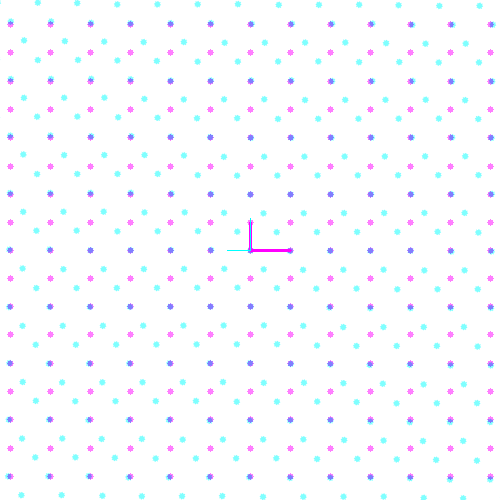

In [12]:
cv2_imshow(out["Substrate(110)//Film(110)"]["image"])